In [2]:
import numpy as np
import argparse
import os
import sys
import random
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils,mask_backward_new
import matplotlib.pyplot as plt
import pdb
# from maskbackward import mask_backward
from mask_backward_new import mask_backward, mask_eval
from utils import mask_complete , mask_makebinary,kplot, mask_filter

sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

#### import data to test mask_backward function

In [3]:
data_gt = np.load('/home/huangz78/data/data_gt.npz')
# datafornn = np.load('/home/huangz78/data/datafornn.npz')

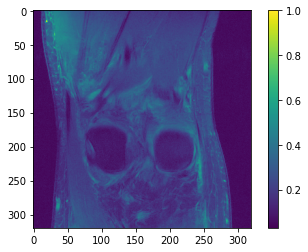

In [4]:
picind = np.random.randint(199)
xstar = data_gt['imgdata'][:,:,picind]
xstar = xstar/np.max(np.abs(xstar))
# highmask = datafornn['labels'][picind,:]
plt.figure()
plt.imshow(xstar)
plt.colorbar()
plt.show()

In [5]:
# reload(maskbackward)
# from maskbackward import mask_backward

#mode UNET:

reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

dtyp = torch.float
# unroll_block = 8; Lambda=6.1e-4; rho=1e1

# base = .05; expand = .15
# highmask = torch.zeros((round(320*(1-base))),dtype=torch.double)
# highmask[np.random.choice(round(320*(1-base)),round(320*expand),replace=False)] = 1
fullmask  = torch.tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],dtype=dtyp)
highmask = mask_filter(fullmask,base=round(320*0.05),roll=True)
print(highmask.shape)

torch.Size([304])


In [6]:
n_channels = 1
UNET =  UNet(n_channels=n_channels,n_classes=n_channels,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_' + str(n_channels) + '.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
UNET.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


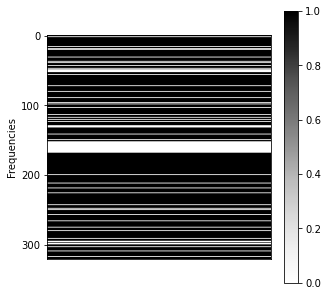

sparsity of fullmask =  0.2


In [7]:
## quick comparison between ifft recon and unet recon
imgHeg = 320; imgWid = 320
fullmask = torch.tensor( mask_complete(highmask,imgHeg,dtyp=torch.float) )
kplot(fullmask)
print('sparsity of fullmask = ',fullmask.sum().item()/imgHeg)

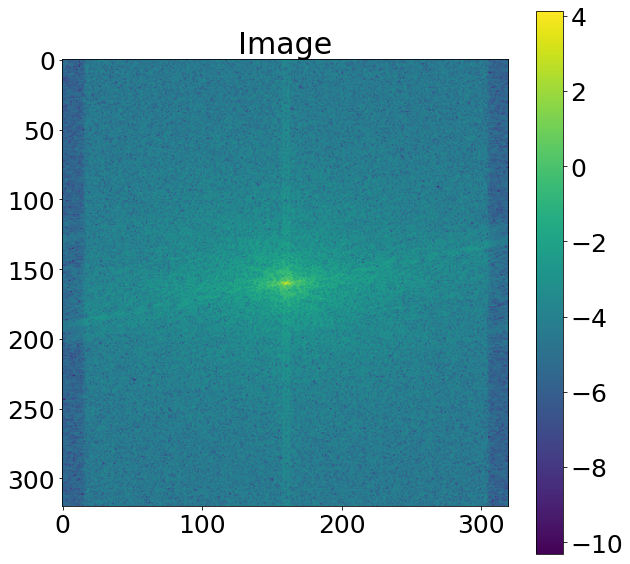

/home/huangz78/mri/utils.py:76: RuntimeWarning: divide by zero encountered in log
  hd1 = axs.imshow(np.log(y),cmap=cmap)
/home/huangz78/mri/utils.py:78: RuntimeWarning: divide by zero encountered in log
  hd1 = axs.imshow(np.log(np.abs(y)),cmap=cmap)


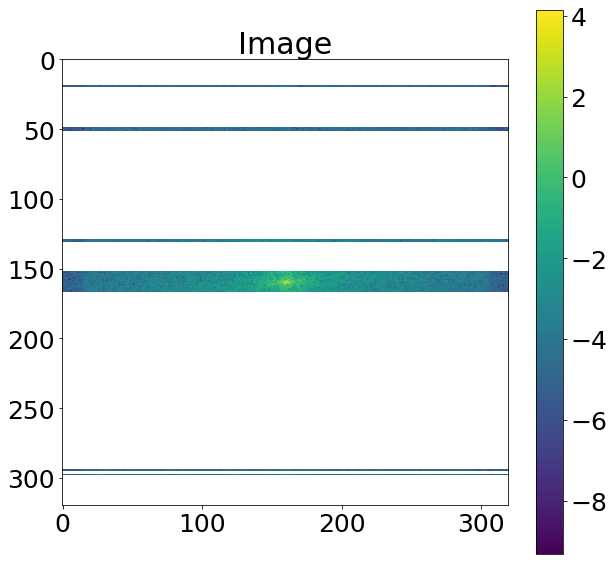

In [8]:
xstar = torch.tensor(xstar,dtype=dtyp)
DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'))
z = torch.fft.ifftshift(torch.tensordot(torch.diag(fullmask).to(DTyp),y,dims=([1],[0])))
kplot(y,roll=False,log=True)
kplot(z,roll=True,log=True)

In [9]:
imgHeg = 320; imgWid = 320
x_ifft = torch.abs(F.ifftn(z,dim=(0,1),norm='ortho')).to(dtyp)
x_unet = UNET(x_ifft.view(1,1,imgHeg,imgWid)).detach()

print('error of x_ifft = ', torch.norm(torch.flatten(x_ifft)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )
print('error of x_unet = ', torch.norm(torch.flatten(x_unet)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )

error of x_ifft =  tensor(0.1319)
error of x_unet =  tensor(0.0942)


1 out of 50
2 out of 50
3 out of 50
4 out of 50
5 out of 50
6 out of 50
7 out of 50
8 out of 50
9 out of 50
10 out of 50
11 out of 50
12 out of 50
13 out of 50
14 out of 50
15 out of 50
16 out of 50
17 out of 50
18 out of 50
19 out of 50
20 out of 50
21 out of 50
22 out of 50
23 out of 50
24 out of 50
25 out of 50
26 out of 50
27 out of 50
28 out of 50
29 out of 50
30 out of 50
31 out of 50
32 out of 50
33 out of 50
34 out of 50
35 out of 50
36 out of 50
37 out of 50
38 out of 50
39 out of 50
40 out of 50
41 out of 50
42 out of 50
43 out of 50
44 out of 50
45 out of 50
46 out of 50
47 out of 50
48 out of 50
49 out of 50
50 out of 50


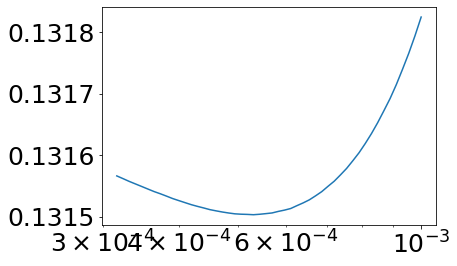

In [22]:
from sigpy.mri.app import TotalVariationRecon
NN = 50
Lambda_grid = 10**np.linspace(-3.5,-3,NN)
errRec = np.zeros((NN))
ind = 1

mps  = np.ones((1,imgHeg,imgWid))
y_sp = np.reshape(z.numpy(),(-1,imgHeg,imgWid))
for Lambda in Lambda_grid:
# Lambda = 10**(-6.31) 
# Lambda = 10**(-3.2755) # np.log10(Lambda_grid[np.argmin(errRec)])
    print('{} out of {}'.format(ind,NN))
    x_sp = np.fft.fftshift( np.abs(TotalVariationRecon(y_sp, mps, Lambda,show_pbar=False).run()) ) 
    x_sp = torch.tensor(x_sp)
    errRec[ind-1] = torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro')
    ind += 1
#     print('error of x_sp = ', torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro'))

plt.figure()
plt.xscale('log')
plt.plot(Lambda_grid,errRec)

In [37]:
np.linspace(-6,-4,gridnum)[8]

-4.222222222222222

In [16]:
reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

maxIter = 200
gridnum = 10
alpha_grid = 10**np.linspace(-4.6,-4.5,gridnum)
sr_rec = np.zeros((gridnum))
mloss_rec = np.zeros(gridnum)

ind = 0
for alpha in alpha_grid:
    print('[{}/{}]  alpha {}'.format(ind+1,gridnum,alpha))
    highmask_refined,refine_mloss,init_loss = mask_backward(highmask,xstar,\
                          beta=1., alpha=alpha,maxIter=maxIter,seed=0,break_limit=maxIter//2,\
                          lr=5e-4,mode='UNET',\
                          verbose=False,dtyp=dtyp)
    print('Difference between masks: \n',highmask_refined - highmask)
#     print('Refined mask is: \n',highmask_refined)
    mloss_rec[ind] = refine_mloss
    sr_rec[ind] = (torch.sum(highmask_refined).item() + 24)/320
    ind += 1

[1/10]  alpha 2.5118864315095822e-05
Unet loaded successfully from : /home/huangz78/mri/checkpoints/unet_1.pth
loss of the input mask:  10.664205998182297

return at Iter:  200
loss of returned mask:  8.692902326583862
Difference between masks: 
 tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.

Unet loaded successfully from : /home/huangz78/mri/checkpoints/unet_1.pth
loss of the input mask:  10.664205998182297

return at Iter:  200
loss of returned mask:  8.947864174842834
Difference between masks: 
 tensor([ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
         1

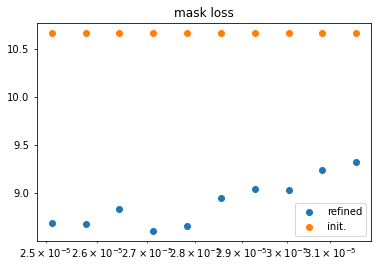

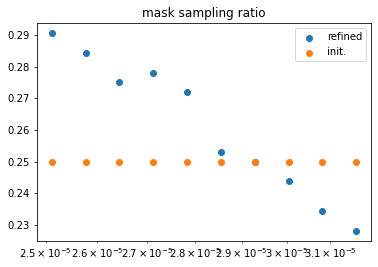

In [17]:
plt.figure()
plt.scatter(alpha_grid,mloss_rec,label='refined')
plt.scatter(alpha_grid,init_loss*np.ones(mloss_rec.shape),label='init.')
plt.title('mask loss')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.scatter(alpha_grid,sr_rec,label='refined')
plt.scatter(alpha_grid,0.25*np.ones(mloss_rec.shape),label='init.')
plt.title('mask sampling ratio')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### arXiv

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward

# mode ADMM:

highmask = torch.zeros((round(320*0.9)))
highmask[np.random.choice(round(320*0.9),int(320*.1),replace=False)] = 1

naive_mloss = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
highmask_refined,refine_mloss = mask_backward(highmask,xstar,\
                          beta=1., alpha=1e1,maxIter=200,unroll_block=unroll_block,seed=0,break_limit=100,\
                          lr=5e-4,mode='ADMM',Lambda=Lambda,rho=rho,\
                          verbose=True,perturb=False,perturb_freq=5,eps=1e-2)

In [ ]:
# vary sampling ratio, observe RMSE for the same image.
reload(mask_backward_new)
from mask_backward_new import mask_backward

base=0.1
r_grid = np.array([0.1,0.15,0.2])
naive_mloss = np.zeros((r_grid.size))
refine_mloss = np.zeros((r_grid.size))

sampRatio = np.zeros((r_grid.size))

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/3)

np.random.seed(0)

ind = 0
for r in r_grid:
    print('\n r {}, the {} item out of {}'.format(r,ind+1,r_grid.size))
    highmask = torch.zeros((round(320*(1-base))))
    highmask[np.random.choice(round(320*(1-base)),int(320*r),replace=False)] = 1
    
    naive_mloss[ind] = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
    highmask_refined,refine_mloss[ind] = mask_backward(highmask,xstar,seed=0,\
                              beta=1., alpha=9.5e0,maxIter=maxIter,unroll_block=unroll_block,break_limit=break_limit,\
                              lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                              verbose=True,perturb=False,perturb_freq=5,eps=1e-2)
    sampRatio[ind] = (highmask_refined.sum().item() + round(320*0.1))/320
    ind += 1

In [ ]:
print('sampRatio: ',sampRatio)
plt.figure()
plt.scatter(r_grid,naive_mloss,label='naive')
plt.scatter(sampRatio,refine_mloss,label='refined')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

In [ ]:
## find a good alpha for l1 penalty
reload(mask_backward_new); reload(utils);
from mask_backward_new import mask_backward
alpha_grid = np.linspace(1,10,10)
sparsity_ = np.zeros(alpha_grid.size)
change_count = np.zeros(alpha_grid.size)

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/2)
# add samp. ratio. = .1 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?

base = 0.05
additional = 0.125

highmask = torch.zeros((round(320*(1-base))))
highmask[np.random.choice(round(320*(1-base)),round(320*additional),replace=False)] = 1

ind = 0
for alpha in alpha_grid:
    print('\n\talpha = {}'.format(alpha))
    highmask_refined,_ = mask_backward(highmask,xstar,\
                  beta=1, alpha=alpha,maxIter=maxIter,unroll_block=unroll_block,seed=0,break_limit=break_limit,\
                  lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                  perturb=False,perturb_freq=10,verbose=True)
    sparsity_[ind] = mask_complete(highmask_refined.to(torch.double),320).sum().item()/320
    change_count[ind] = torch.abs(highmask_refined - highmask).sum().item()
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,sparsity_,label='end')
plt.scatter(alpha_grid,(base+additional)*np.ones(alpha_grid.size),label='start')
plt.title('sparsity')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

plt.figure()
plt.scatter(alpha_grid,change_count)
# plt.xscale('log')
plt.title('change count')

In [ ]:
naive_mloss = mask_eval(mask_complete(highmask,imgHeg,dtyp=dtyp),xstar,mode='UNET',UNET=UNET,dtyp=dtyp) * 100
print('naive mask loss = ',naive_mloss)